# MIE1624 Introduction to Data Science and Analytics

## Assignment#2 Sentiment Analysis

## Zichuan Wang - 1000474300

## 0. Learning objectives:

1. Implement functionality to parse and clean data according to given requirements. 
2. Understand how exploring the data by creating visualizations leads to a deeper understanding of the data.
3. Learn about training and testing machine learning algorithms (logistic regression, k-NN, decision trees, random forest, XGBoost).
4. Understand how to apply machine learning algorithms to the task of text classification. 
5. Improve on skills and competencies required to collate and present domain specific, evidence-based insights.

### 0.1 Import libraries:

In [36]:
#!pip install --upgrade pip
#!pip3 install pandas numpy 
#!pip3 install 
#!pip3 install HTMLParser 
#!pip3 install nltk 
#!pip3 install wordcloud

In [37]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zichuanwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zichuanwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zichuanwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
import pandas as pd
import numpy as np
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata
import re
import html
from collections import Counter
from functools import reduce
from scipy import stats
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
#from autocorrect import spell
from wordcloud import WordCloud
%matplotlib inline

import random
random.seed()

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set pandas view options
pd.set_option('max_rows',20)
pd.set_option('max_columns',800)

## 1. Data cleaning (20 marks):

The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’. Therefore, the first step is to “clean” the data. Design a procedure that prepares the Twitter data for analysis by satisfying the requirements below.  
o All html tags and attributes (i.e., /<[^>]+>/) are removed.  
o Html character codes (i.e., &...;) are replaced with an ASCII equivalent.  
o All URLs are removed.  
o All characters in the text are in lowercase.  
o All stop words are removed. Be clear in what you consider as a stop word.  
o If a tweet is empty after pre-processing, it should be preserved as such.  

### 1.1 Import original data and stop words

In [39]:
generic_tweets = pd.read_csv('Sentiment.csv')
generic_tweets.head(5)

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


In [40]:
election_tweets = pd.read_csv('Canadian_elections_2019.csv')
election_tweets.head(5)

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [41]:
class DataCleaner(object):
    def __init__(self,stop_words=[""], remove_steps = []):
        super().__init__()
        self.hashtags = str()
        self.remove_steps = remove_steps
        self.stop_words = stop_words
        self.procedures = [getattr(self,procedure) for procedure in \
                        [step for step in sorted(dir(self)) if step.startswith("step_")]]
        # remove some procedures according to users' needs
        for i in sorted(self.remove_steps,reverse=True):
                self.procedures.pop(i-1)

    #use reduce to sequentially clean the raw data, equivelent to funcN(...func2(func1(data)))
    def clean(self, data):
            return reduce(lambda data,func:func(data),[data]+self.procedures), self.hashtags

    # Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    def step_01_to_ascii(self, data):
        return html.unescape(data)

    # Remove html tags and attributes in form of <...>
    def step_02_remove_html_tag(self, data):
        return re.sub(r"\s*<.*?>",'', data)

    # Remove url in form of (http or https://)address.domain(/file)
    def step_03_remove_url(self, data):
        return re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',data)

    # Change all characters in the text to lowercase.
    def step_04_to_lower(self, data):
        return data.lower()

    # Collect @ tag message
    def step_05_hashtag_collection(self,data):
        self.hashtags = ' '.join(re.findall(r'(?<=@)[^\s]+\s?',data))
        return re.sub(r'@.*?\s','',data)

    # Tokenize the word stream
    def step_06_tokenization(self,data):
        tokenizer = RegexpTokenizer(r'\w+')
        words_list = tokenizer.tokenize(data)
        return ' '.join(words_list)

    # Remove stop words
    def step_07_remove_stop_words(self,data):
        words = data.split()
        new_data = [word for word in words if word not in self.stop_words]
        return ' '.join(new_data) # clean up empty charactor

    # Remove non alphanumeric characters except space
    def step_08_remove_nonAlphaNumerical(self,data):
        return re.sub(r'[^\s\w]+','',data)

In [42]:
generic_tweets['text'] = generic_tweets['text'].apply(str)
stop_words = stopwords.words("english")
geneCleaner = DataCleaner(stop_words,[5])
generic_tweets['cleaned'],_ = np.vectorize(geneCleaner.clean)(generic_tweets['text'])
generic_tweets['cleaned'] = generic_tweets['cleaned'].str.replace(r'\bx\w+\b', '')
generic_tweets['cleaned'] = generic_tweets['cleaned'].str.replace(r'\b[0-9]\w*\b', '')
generic_tweets['cleaned'] = generic_tweets['cleaned'].str.replace(r'\b_\w*\b', '')
generic_tweets['cleaned'] = generic_tweets['cleaned'].str.replace(r'\ba[0-9_a]\w*\b', '')
# generic_tweets['cleaned'] = generic_tweets['cleaned'].str.split()
generic_tweets.head(3)

,sentiment,text,cleaned
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,rt diplomtc_immnty realdonaldtrump tried take ...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...",chiefy74 damn jealous wanna watch fight love u...
2,Positive,I'm listening The Beatles now. They're great,listening beatles great


In [43]:
election_tweets['text'] = election_tweets['text'].apply(str)
stop_words = stopwords.words("english") + ['cdnpoli','elxn43','retweeted','cdnelxn2019', 'elxn2019']
geneCleaner = DataCleaner(stop_words,[5])
election_tweets['cleaned'],_ = np.vectorize(geneCleaner.clean)(election_tweets['text'])
election_tweets['cleaned'] = election_tweets['cleaned'].str.replace(r'^b\s', '')
election_tweets['cleaned'] = election_tweets['cleaned'].str.replace(r'\bx\w+\b', '')
election_tweets['cleaned'] = election_tweets['cleaned'].str.replace(r'\b[0-9]\w*\b', '')
# election_tweets['cleaned'] = election_tweets['cleaned'].str.split()
election_tweets.head(3)

,sentiment,negative_reason,text,cleaned
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...",rosiebarton instead suggestion agree canadian ...
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...",allwomanspacewalk real n space_station n etobi...
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...",brantford going cost billion next years ask ...


## 2. Exploratory analysis (15 marks):

1. Design a simple procedure that determines the political party (Liberal, Conservative, NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019 Canadian elections dataset. A suggestion would be to look at relevant words and hashtags in the tweets that identify to certain political parties. What can you say about the distribution of the political affiliations of the tweets?  
  
  
2. Present a graphical figure (e.g. chart, graph, histogram, boxplot, word cloud, etc) that visualizes some aspect of the generic tweets from Sentiment.csv file and another figure for the 2019 Canadian election tweets. All graphs and plots should be readable and have all axes that are appropriately labelled.

### 2.1 Determine the Political Party

**Top 6 Canadian Political Parties in 2019 Canadian Federal election** 
1. **Liberal Party**
   - leader: Justin Trudeau  
   - Slogans: "Choose Forwrd"  
   - key words: justin, trudeau, justintrudeau, chooseforward, liberal,red 
2. **Conservative Party**
   - leader: Andrew Scheer
   - Slogans: "It is time for you to get ahead"
   - key words: andrew, scheer, andrewscheer, conservative ,getahead
3. **New Democratic Party**
   - leader: Jagmeet Singh
   - Slogans: "In it for you"
   - key words: jagmeet, singh, jagmeetsingh, newdemocratic, ndp, orange
4. **Bloc Quebecois**
   - leader: Yves-François Blanchet
   - Slogans:"It is us"
   - key words: yves, blanchet, blocquebecois, bloc, quebecois, bq
5. **Green Party**
   - leader: Elizabeth May
   - Slogans: "Not left.Not right. Forward together"
   - key words: elizabeth, elizabethmay, green, notleftnotrightforwardtogether
6. **People's Party**  
   - leader: Maxime Bernier
   - Slogans: "Strong and Free"
   - key words: maxime, bernier,renata,ford,renataford,maximebernier, strongandfree, ppc, peoplespartyofcanada

We defined a function called party_name which compares the frequency of different keywords for each party in a single tweet and returns the **most common party name**.

In [44]:
def party_name(tw_list):
    '''
    Input: a single tweet
    Output: party name 
    '''
    tw = tw_list
    # keywords of each party
    Liberal =['trudeau', "justin", "justintrudeau", "liberal","liberals","chooseforward","forward","red","trudeaumustgo","liberal_party"] 
    Conservative=["andrew", "scheer", "andrewscheer","conservative", "conservatives","getahead","cpc","cpc_hq"]
    NDP=["ndp","orange","jagmeet","singh","jagmeetsingh","newdemocratic","initforyou"]
    BQ=["yvesfrancois","blanchet","yvesfrancoisblanchet","blocquebecois","bq","quebecois","bloc","itisus"]
    Green = ["green","elizabeth","elizabethmay","notleftnotrightforwardtogether"]
    PPC=["maxime", "bernier", "maximebernier", "renata","ford","renataford","strongandfree", "ppc", "peoplespartyofcanada"]
    
    party = []
        
    for key in Liberal:   
        if key in tw:
            party.append('Liberal Party')
        
    for key in Conservative:
        if key in tw:
            party.append('Conservative Party')
           
    for key in NDP:
        if key in tw:
            party.append('New Democratic Party')
            
    for key in BQ:
        if key in tw:
            party.append('Bloc Quebecois')
            
    for key in Green:
        if key in tw:
            party.append('Green Party')
            
    for key in PPC:
        if key in tw:
            party.append("People's Party")
            
    # choose the most common party name for this tweet
    if len(party) > 1:
        most_common = max(set(party), key=party.count)
        party = []
        party.append(most_common)
    elif len(party) == 0:
        party.append('Other')
        
    return party

In [45]:
# put each tweet in to corresponding party list
election_tweets['party']='Other'
canadianelections_liberal_tweet = []
canadianelections_conservative_tweet = []
canadianelections_ndp_tweet = []
canadianelections_bq_tweet=[]
canadianelections_green_tweet=[]
canadianelections_ppc_tweet=[]

for i in range(len(election_tweets)):   
    party_determinant= party_name(election_tweets.cleaned[i])[0]
    election_tweets["party"][i]=party_determinant
    if party_determinant == 'Liberal Party':
        canadianelections_liberal_tweet.append(election_tweets.cleaned[i])
    elif party_determinant == 'Conservative Party':
        canadianelections_conservative_tweet.append(election_tweets.cleaned[i])
    elif party_determinant == 'New Democratic Party':
        canadianelections_ndp_tweet.append(election_tweets.cleaned[i])
    elif party_determinant == 'Bloc Quebecois':
        canadianelections_bq_tweet.append(election_tweets.cleaned[i])
    elif party_determinant == 'Green Party':
        canadianelections_green_tweet.append(election_tweets.cleaned[i])
    elif party_determinant == "People's Party":
        canadianelections_ppc_tweet.append(election_tweets.cleaned[i])   

**Plot the distribution of the political affiliations of the tweets**

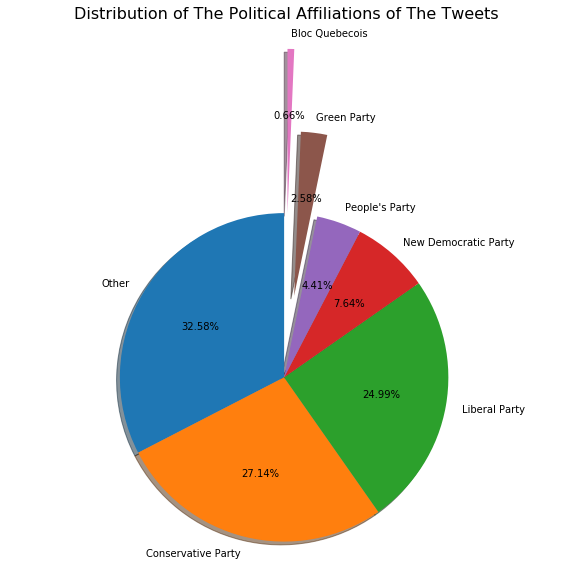

In [46]:
labels = list(election_tweets['party'].value_counts().keys())
sizes = list(election_tweets['party'].value_counts().values)
explode = (0, 0, 0, 0, 0, 0.5, 1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', startangle=90, shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('Distribution of The Political Affiliations of The Tweets', fontsize=16)
plt.show()

From the distribution, it is not surprising that the majority of tweets are labeled as "Other" since they don't contain any party specific keywords.

Besides, Conservative Party has the highest tweets percentage followed closely by Liberal Party. This is to be expected since they are two main competitors in 2019 Canadian Federal election.

### 2.2 Visualization of Data

#### 2.2.1 Visualization of Generic Tweets

In [47]:
generic_tweets['cleaned'] = generic_tweets['cleaned'].str.split()

#### WordCloud to show the public's positive voice in generic tweets. 

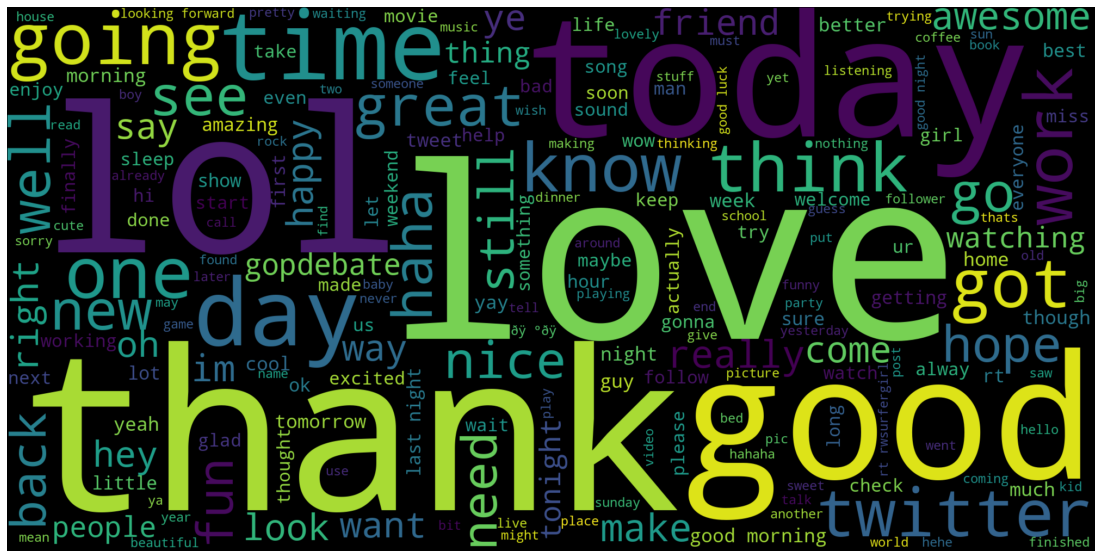

In [48]:
generic_positive=generic_tweets[generic_tweets['sentiment']=='Positive']['cleaned'].apply(lambda x:" ".join(x))
generic_positive_wordcloud=" ".join(generic_positive)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 1000,max_words=200,background_color="black").generate(generic_positive_wordcloud)
# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### From the word cloud of population's positive voice, we can see that positive tweets have some key words like "good","love","great". And some other key words including "hope", "going", "will". It seems that positive tweets show people's hope and plan about future.

#### WordCloud to show the public's negative voice in generic tweets. 

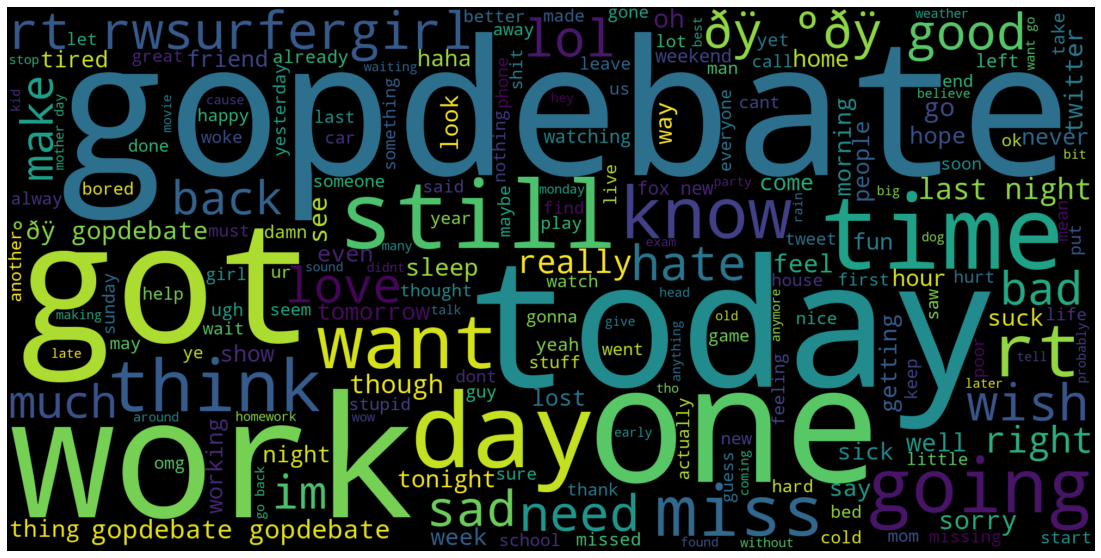

In [49]:
generic_negative=generic_tweets[generic_tweets['sentiment']=='Negative']['cleaned'].apply(lambda x:" ".join(x))
generic_negative_wordcloud=" ".join(generic_negative)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 1000,max_words=200,background_color="black").generate(generic_negative_wordcloud)
# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### From the word cloud of population's negative voice, we can see that negative tweets have some key words like "work","hate","bad".It seems that negative tweets show people's reluctance to work.

#### 2.2.2 Visualization of Election Tweets

#### WordCloud to show the public's positive voice in election tweets. 

In [50]:
election_tweets['cleaned'] = election_tweets['cleaned'].str.split()

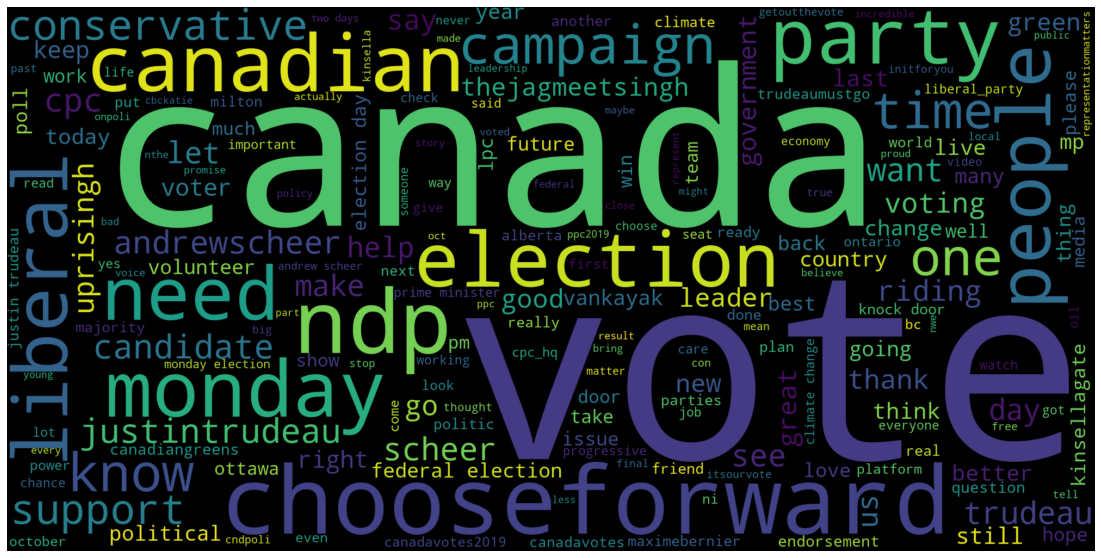

In [51]:
election_positive=election_tweets[election_tweets['sentiment']=='Positive']['cleaned'].apply(lambda x:" ".join(x))
election_positive_wordcloud=" ".join(election_positive)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 1000,max_words=200,background_color="black").generate(election_positive_wordcloud)
# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### From the word cloud of election's positive voice, we can see that positive tweets have some key words like "help", "support". And some other Liberal Party related keywords like "chooseforwad" and "liberal"."bad". It's not surprising that Liberal Party is the final winner.

#### WordCloud to show the public's negative voice in election tweets. 

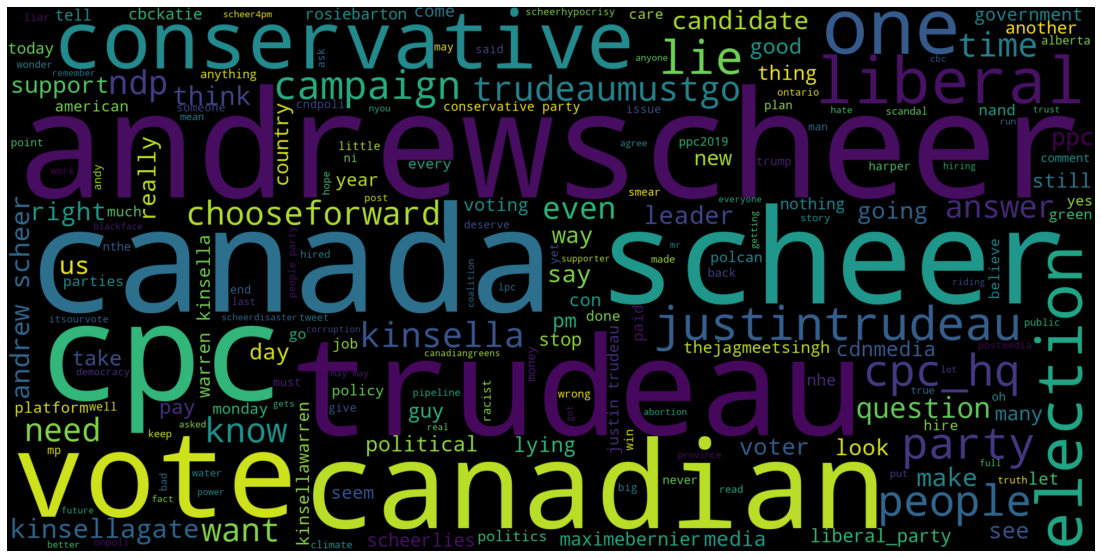

In [52]:
election_negative=election_tweets[election_tweets['sentiment']=='Negative']['cleaned'].apply(lambda x:" ".join(x))
election_negative_wordcloud=" ".join(election_negative)
# Create and generate a word cloud image:
wordcloud = WordCloud(width = 2000, height = 1000,max_words=200,background_color="black").generate(election_negative_wordcloud)
# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### From the word cloud of election's negative voice, we can see that negative tweets primarily consists of Conservative Party related keywords like "conservative", "andewscheer" and "cpc". It's not surprising that Conservative Party didn't prevail eventually.

### 2.3 Exploratory analysis Bonus

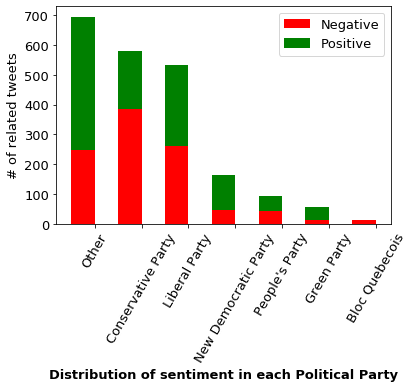

In [125]:
def ratio_2d(dataFrame,class1,attr1,label2,attr2):
    num = []
    nega = []
    for i in class1:
        num.append(dataFrame[dataFrame[attr1]==i].iloc[:,0].count())
        nega.append(dataFrame[(dataFrame[attr1]==i) & (dataFrame[attr2]==label2)].iloc[:,0].count())
    num = np.array(num)
    nega = np.array(nega)
    ratio = nega / num
    return num,ratio

parties=['Other','Conservative Party','Liberal Party','New Democratic Party',"People's Party",'Green Party','Bloc Quebecois']
num,ratio = ratio_2d(election_tweets,parties,'party','Negative','sentiment')

negative = num * ratio
positive = num * (1-ratio)

plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(parties))
plt.bar(idx, negative, width, color='red', label='Negative')
plt.bar(idx, positive, width, bottom=negative, color='green', label='Positive')
plt.xlabel('Distribution of sentiment in each Political Party',fontweight='bold')
plt.ylabel('# of related tweets')
plt.xticks(idx+width/2, parties, rotation=60)
plt.legend()

The above figure demonstrates that Conservative Party has the highest popularity, followed closely by Liberal Party. But the negative portion of the Conservative Party is the highest amongst all parties. This is a good indicator on why Conservative Party lost in the election.

In [122]:
neg_reasons = ['Others',
               'Scandal',
               'Tell lies',
               'Economy',
               'Women Reproductive right and Racism',
               'Climate Problem',
               'Separation',
               'Privilege',
               'Healthcare',
               'Healthcare and Marijuana']

In [123]:
neg_election_tweets = election_tweets[election_tweets['sentiment']=='Negative']
#neg_reasons = list(set(neg_election_tweets['negative_reason']))
num_neg_reason,ratio_neg_reason = ratio_2d(election_tweets,neg_reasons,'negative_reason','negative','sentiment')

(-1.1185071383779093,
 1.1204279079716353,
 -1.1529764737520303,
 2.1500601686346763)

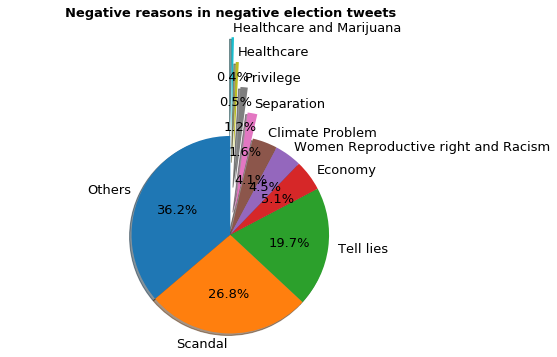

In [124]:
plt.figure(figsize=(8,6))

fig = plt.plot()
plt.title('Negative reasons in negative election tweets',fontsize=13,fontweight='bold')
plt.pie(num_neg_reason,labels=neg_reasons,explode=(0,0,0,0,0,0,0.25,0.50,0.75,1.0),\
       labeldistance = 1.1,autopct = '%3.1f%%',shadow = True, startangle = 90,pctdistance = 0.6)
plt.axis('equal')

The above figure demonstrate the negative reasons distribution amongst all negative election related tweets. Scandal and Tell lies have the highest percentage besides others. This shows that people cares more about whether the elected government is honest or not.

## 3. Model preparation (15 marks):

Split the generic tweets from Sentiment.csv file randomly into training data (70%) and test data (30%). Prepare the data to try multiple classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)), where each tweet is considered a single observation/example. In these models, the target variable is the sentiment value, which is either positive or negative. Try two different types of features, word frequency (WF) and TF-IDF.

### 3.1 Text Feature Extraction
DataGenerator class is responsible for extracting text features using different method, namely word frequency (WF) and TF-IDF. **Train test split** feature is also integrated into the class.

In [56]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

class DataGenerator(object):
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame

    def generate(self,feature_column,label_column,method="tf-idf",top=1000):
        if method=="tf-idf":
            return self._generate_tf_idf(feature_column,label_column)
        elif method=="wf":
            return self._generate_wf(feature_column,label_column)
        else:
            print("Please check your data generation method.")
            return None

    # TF-IDF
    def _generate_tf_idf(self,feature_column,label_column):
        # transform all text data into TF-IDF features
        count_vector = CountVectorizer(stop_words='english')
        X = count_vector.fit_transform(self.dataFrame[feature_column].apply(lambda x:" ".join(x)))
        Y = self.dataFrame[label_column]
        return X,Y,count_vector
    
    # WF
    def _generate_wf(self,feature_column,label_column):
        # transform all text data into WF features
        tfidf_vector = TfidfVectorizer(stop_words='english')
        X = tfidf_vector.fit_transform(self.dataFrame[feature_column].apply(lambda x:" ".join(x)))
        Y = self.dataFrame[label_column]
        return X,Y,tfidf_vector

    def split_data(self,X,Y,percent=[0.7,0.3],random_state=42):
        # train test split of 70% and 30%
        if len(percent) == 2:
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            return X_train,X_test,y_train,y_test
        elif len(percent) == 3:
            print("You also create validation set...")
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=percent[2]/(1-percent[1]), random_state=random_state)
            return X_train,X_valid,X_test,y_train,y_valid,y_test
        else:
            print("Please check you percent.\n")
            return None

Convert sentiment labels of Postive and Negative to numeric class labels of 0 and 1.

In [57]:
generic_tweets['class'] = [1 if row['sentiment']=='Positive' else 0 for index,row in generic_tweets.iterrows()]
generic_tweets.head()

,sentiment,text,cleaned,class
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...,"[rt, diplomtc_immnty, realdonaldtrump, tried, ...",1
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ...","[chiefy74, damn, jealous, wanna, watch, fight,...",0
2,Positive,I'm listening The Beatles now. They're great,"[listening, beatles, great]",1
3,Positive,@ddlovato could i please get a shout out or an...,"[ddlovato, could, please, get, shout, anything...",1
4,Positive,@salspizza just spotted ur message there Tony ...,"[salspizza, spotted, ur, message, tony, replied]",1


### 3.2 TF-IDF
#### Train test split of 70% and 30% is applied before data is fed into the model.

In [58]:
geneGenerator = DataGenerator(generic_tweets)

In [59]:
generic_X_tf, generic_Y_tf, feature_list_tf = geneGenerator.generate("cleaned","class","tf-idf")
generic_X_train_tf,generic_X_test_tf,generic_y_train_tf,generic_y_test_tf = \
geneGenerator.split_data(generic_X_tf,generic_Y_tf,percent=[0.7,0.3])

### 3.3 Word Frequency (WF)
#### Train test split of 70% and 30% is applied before data is fed into the model.

In [60]:
geneGenerator = DataGenerator(generic_tweets)

In [61]:
generic_X_wf, generic_Y_wf, feature_list_wf = geneGenerator.generate("cleaned","class","wf")
generic_X_train_wf,generic_X_test_wf,generic_y_train_wf,generic_y_test_wf = \
geneGenerator.split_data(generic_X_wf,generic_Y_wf,percent=[0.7,0.3])

## 4 Model implementation (30 marks):
**Task1**

For data from Sentiment.csv file, train models on the training data, tune the hyperparameters (if necessary, with cross-validation) and apply the model to the test data to obtain an accuracy value. Evaluate the same model with best performance on the 2019 Canadian elections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?

**Task2**

Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties. Compare your modeling results with election outcome. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

**Task3**

Split the negative 2019 Canadian elections tweets into training data (70%) and test data (30%). Use the sentiment labels in the 2019 Canadian elections data instead of your predictions from the previous part. Choose three algorithms from classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)), train multi-class classification models to predict the reason for the negative tweets. There are 10 different negative reasons labelled in the dataset. Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques.

In [79]:
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import LinearSVC as lsvc
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import GradientBoostingClassifier as gb
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

class Classifier(object):
    def __init__(self,train_data,train_labels):
        super().__init__()
        self.train_data = train_data
        self.train_labels = train_labels
        self.models=OrderedDict([('LogisticRegression',[lr(C=1.0),dict(C=np.arange(0.1,3,0.2))]),\
                                 ('MultinomialNB',[mnb(alpha=5.0),dict(alpha=np.arange(0.1,10,1))]),\
                                 ('BernoulliNB',[bnb(alpha=5.0),dict(alpha=np.arange(0.1,10,1))]),\
                                 ('KNeighborsClassifier',[knn(n_neighbors=5),dict(n_neighbors=np.arange(3,7,2))]),\
                                 ('LinearSVC',[lsvc(C=0.1),dict(C=np.arange(0.1,3,0.2))]),\
                                 ('DecisionTreeClassifier',[dt(criterion='gini'),dict(criterion=('gini','entropy'))]),\
                                 ('RandomForestClassifier',[rf(n_estimators=40,random_state=0),dict(n_estimators=np.arange(10,50,10))]),\
                                 ('GradientBoostingClassifier',[gb(n_estimators=20),dict(n_estimators=np.arange(10,30,10))])
                                ])
        #1.1 and 2.70
    def train_model(self,model_name,ifhyper_tune=False,hyper_paras=""):
        model = self.models[model_name][0]
        if model_name == 'LinearSVC' and ifhyper_tune==False:
            model = CalibratedClassifierCV(model)
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 5-fold cross validation
            if hyper_paras:
                grid = GridSearchCV(model, hyper_paras, cv=5, scoring='accuracy', n_jobs=-1) 

                grid.fit(self.train_data, self.train_labels)
                print('The best score of model {} through 5-cross validation is {}, with the best hyper-parameter {}\n'\
                    .format(model_name, grid.best_score_, grid.best_params_))

                # Best model
                best_model = grid.best_estimator_
            else:
                best_model = model.fit(self.train_data,self.train_labels)
        else:
            best_model = model.fit(self.train_data,self.train_labels)
        train_pred = best_model.predict(self.train_data)
        print('Train accuracy of {} model is {}\n'.format(model_name,accuracy_score(self.train_labels,train_pred)))
        return best_model, accuracy_score(self.train_labels,train_pred)

    def test_model(self,best_model,test_data,test_labels,if_report=False,model_name=""):
        test_pred = best_model.predict(test_data)
        
        cm = confusion_matrix(test_labels, test_pred)
        #test accuracy
        print('Model {} has test accuracy {}\n'.format(model_name, accuracy_score(test_labels,test_pred)))
        #test result report
        if if_report:
            print('Test result report:\n\n', classification_report(test_labels, test_pred),'\n')
            if len(set(test_labels))==2 and model_name!='LinearSVC':
                test_score = best_model.predict_proba(test_data)
                print('ROC plot and corresponding AUC:\n')
                self.plot_roc(test_labels,test_score)
            elif len(set(test_labels))>2:
                self.plot_confusion_matrix(cm)
        return accuracy_score(test_labels,test_pred),cm

    def plot_roc(self,true, score):
        preds = score[:,1]
        fpr, tpr, threshold = roc_curve(true, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    def plot_confusion_matrix(self,cm):
        # plot the confusion matrix
        plt.figure(figsize=(10,10))
        plt.matshow(cm, fignum=1)

        # add labels for all targets
        num_targets = cm.shape[0]
        plt.xticks(list(range(num_targets+1)))
        plt.yticks(list(range(num_targets+1)))

### 4.1 Task 1 

As mentioned in section 3, multiple classification algorithms **(logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost))** need to be implemented and compared. Since TF-IDF is more effective at minimizing the effect of meaningless common words that show up at lot, TF-IDF will be our main feature extraction technique for the rest of this section. Word frequency will be used once for Naive Bayes just for demonstration purpose. **5-fold cross validation** is universally applied to all algorithems.

In [63]:
geneClassifier_wf = Classifier(generic_X_train_wf,generic_y_train_wf)

Model Training and Hyper-parameters Tuning for LogisticRegression

TRAIN PERFORMANCE:
The best score of model MultinomialNB through 5-cross validation is 0.7318586054853897, with the best hyper-parameter {'alpha': 0.1}

Train accuracy of MultinomialNB model is 0.9061462414724503

TEST PERFORMANCE:
Model MultinomialNB has test accuracy 0.7355520127540853

Test result report:

               precision    recall  f1-score   support

           0       0.74      0.80      0.77     22357
           1       0.72      0.65      0.69     17787

    accuracy                           0.74     40144
   macro avg       0.73      0.73      0.73     40144
weighted avg       0.73      0.74      0.73     40144
 

ROC plot and corresponding AUC:



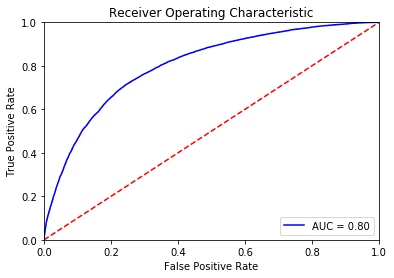

In [111]:
print("Model Training and Hyper-parameters Tuning for LogisticRegression\n")
print("TRAIN PERFORMANCE:")
generic_wf_nb, _ = geneClassifier_wf.train_model('MultinomialNB', True)
print("TEST PERFORMANCE:")
result = geneClassifier_wf.test_model(generic_wf_nb,generic_X_test_wf,generic_y_test_wf,
                                      True,model_name="MultinomialNB")

#### 4.1.1 For data from Sentiment.csv file, train models on the training data, tune the hyperparameters (if necessary, with cross-validation) and apply the model to the test data to obtain an accuracy value.
#### Logistic Regression：

Regularization parameter C is used in hyperparameter tuning. Best performance model was found when **C=1.7**. Model trained on generic_tweeters got the training accuracy of **86.3%**, and got the test accuracy of **76.7%**.

In [64]:
geneClassifier_tf = Classifier(generic_X_train_tf,generic_y_train_tf)

Model Training and Hyper-parameters Tuning for LogisticRegression

TRAIN PERFORMANCE:
The best score of model LogisticRegression through 5-cross validation is 0.7651040387756627, with the best hyper-parameter {'C': 1.7000000000000004}

Train accuracy of LogisticRegression model is 0.8629613417745844

TEST PERFORMANCE:
Model LogisticRegression has test accuracy 0.7667895575926664

Test result report:

               precision    recall  f1-score   support

           0       0.79      0.79      0.79     22357
           1       0.74      0.73      0.74     17787

    accuracy                           0.77     40144
   macro avg       0.76      0.76      0.76     40144
weighted avg       0.77      0.77      0.77     40144
 

ROC plot and corresponding AUC:



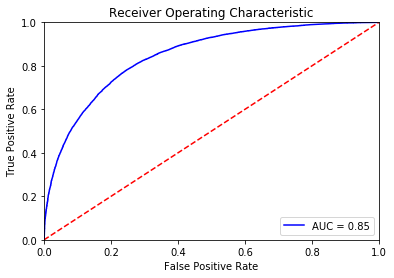

In [31]:
print("Model Training and Hyper-parameters Tuning for LogisticRegression\n")
print("TRAIN PERFORMANCE:")
generic_tf_lr, _ = geneClassifier_tf.train_model('LogisticRegression', True)
print("TEST PERFORMANCE:")
result = geneClassifier_tf.test_model(generic_tf_lr,generic_X_test_tf,generic_y_test_tf,True,model_name="LogisticRegression")

#### Naive Bayes:

Laplace smoothing parameter alpha is used in hyperparameter tuning. Best performance model was found when **alpha=1.1**. Model trained on generic_tweeters got the training accuracy of **85.9%**, and got the test accuracy of **75.6%**.

Model Training and Hyper-parameters Tuning for Naive Bayes

TRAIN PERFORMANCE:
The best score of model BernoulliNB through 5-cross validation is 0.7526236561435724, with the best hyper-parameter {'alpha': 1.1}

Train accuracy of BernoulliNB model is 0.8593314614538738

TEST PERFORMANCE:
Model BernoulliNB has test accuracy 0.7559784774810682

Test result report:

               precision    recall  f1-score   support

           0       0.76      0.82      0.79     22357
           1       0.75      0.68      0.71     17787

    accuracy                           0.76     40144
   macro avg       0.75      0.75      0.75     40144
weighted avg       0.76      0.76      0.75     40144
 

ROC plot and corresponding AUC:



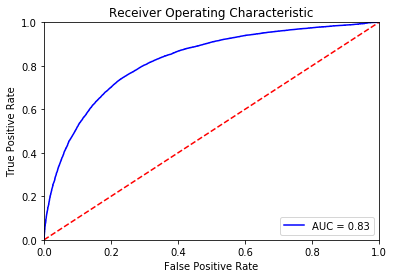

In [32]:
print("Model Training and Hyper-parameters Tuning for Naive Bayes\n")
print("TRAIN PERFORMANCE:")
generic_tf_nb, _ = geneClassifier_tf.train_model('BernoulliNB', True)
print("TEST PERFORMANCE:")
result = geneClassifier_tf.test_model(generic_tf_nb,generic_X_test_tf,generic_y_test_tf,True,model_name="BernoulliNB")

#### K-Nearest Neighbors:

Model with the default setting of **n_neighbors=5** trained on generic_tweeters only got the training accuracy of **71.3%**, and got the test accuracy of **57.5%**. Since KNN's performance is significantly worse than over algorithms and training KNN with large number of neighbors is really time consuming, I decided not to conduct grid search on KNN.

Model Training and Hyper-parameters Tuning for K Nearest Neighbors

TRAIN PERFORMANCE:
Train accuracy of KNeighborsClassifier model is 0.7134743292728496

TEST PERFORMANCE:
Model KNeighborsClassifier has test accuracy 0.5754533678756477

Test result report:

               precision    recall  f1-score   support

           0       0.59      0.80      0.68     22357
           1       0.54      0.29      0.38     17787

    accuracy                           0.58     40144
   macro avg       0.56      0.55      0.53     40144
weighted avg       0.57      0.58      0.54     40144
 

ROC plot and corresponding AUC:



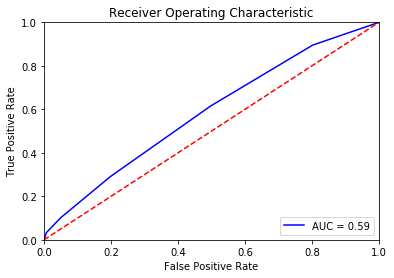

In [37]:
print("Model Training and Hyper-parameters Tuning for K Nearest Neighbors\n")
print("TRAIN PERFORMANCE:")
generic_tf_nb, _ = geneClassifier_tf.train_model('KNeighborsClassifier')
print("TEST PERFORMANCE:")
result = geneClassifier_tf.test_model(generic_tf_nb,generic_X_test_tf,generic_y_test_tf,True,model_name="KNeighborsClassifier")

#### SVM (Linear SVC):

Regularization parameter C is used in hyperparameter tuning. Best performance model was found when **C=0.1**. Model trained on generic_tweeters got the training accuracy of **84.4%**, and got the test accuracy of **76.7%**.

In [104]:
print("Model Training and Hyper-parameters Tuning for Linear SVC\n")
print("TRAIN PERFORMANCE:")
generic_tf_lsvc, _ = geneClassifier_tf.train_model('LinearSVC', True)
print("TEST PERFORMANCE:")
result = geneClassifier_tf.test_model(generic_tf_lsvc,generic_X_test_tf,generic_y_test_tf,True,model_name="LinearSVC")

Model Training and Hyper-parameters Tuning for Linear SVC

TRAIN PERFORMANCE:
The best score of model LinearSVC through 5-cross validation is 0.76468767015064, with the best hyper-parameter {'C': 0.1}

Train accuracy of LinearSVC model is 0.8443101625972861

TEST PERFORMANCE:
Model LinearSVC has test accuracy 0.7673624950179354

Test result report:

               precision    recall  f1-score   support

           0       0.79      0.80      0.79     22357
           1       0.74      0.73      0.74     17787

    accuracy                           0.77     40144
   macro avg       0.76      0.76      0.76     40144
weighted avg       0.77      0.77      0.77     40144
 



#### Decision Tree:

Spliting criterion is used in hyperparameter tuning. Best performance model was found when using Gini impurity rather than entropy. Model trained on generic_tweeters got the training accuracy of **99.4%**, and got the test accuracy of **70.0%**. Despite the nearly perfect score on training accuracy, decision tree don't not generalize well.

Model Training and Hyper-parameters Tuning for Decision Tree

TRAIN PERFORMANCE:
The best score of model DecisionTreeClassifier through 5-cross validation is 0.7010366511151206, with the best hyper-parameter {'criterion': 'gini'}

Train accuracy of DecisionTreeClassifier model is 0.9941815153682727

TEST PERFORMANCE:
Model DecisionTreeClassifier has test accuracy 0.6997060581905141

Test result report:

               precision    recall  f1-score   support

           0       0.72      0.75      0.74     22357
           1       0.67      0.64      0.65     17787

    accuracy                           0.70     40144
   macro avg       0.70      0.69      0.69     40144
weighted avg       0.70      0.70      0.70     40144
 

ROC plot and corresponding AUC:



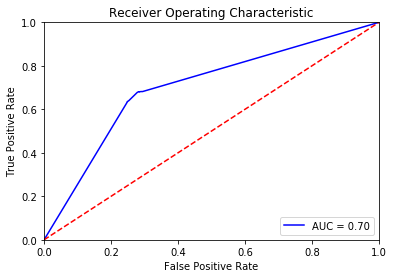

In [34]:
print("Model Training and Hyper-parameters Tuning for Decision Tree\n")
print("TRAIN PERFORMANCE:")
generic_tf_dt, _ = geneClassifier_tf.train_model('DecisionTreeClassifier', True)
print("TEST PERFORMANCE:")
result = geneClassifier_tf.test_model(generic_tf_dt,generic_X_test_tf,generic_y_test_tf,True,model_name="DecisionTreeClassifier")

#### Random Forest:

Number of trees n_estimators is used in hyperparameter tuning. Best performance model was found when **n_estimators=40**. Model trained on generic_tweeters got the training accuracy of **99.4%**, and got the test accuracy of **74.6%**.
##### As this process takes much time and much memory space, I commented them and just showed the result.

Model Training and Hyper-parameters Tuning for Random Forest

TRAIN PERFORMANCE:
The best score of model RandomForestClassifier through 5-cross validation is 0.7452144298418867, with the best hyper-parameter {'n_estimators': 40}

Train accuracy of RandomForestClassifier model is 0.9938398795733823

TEST PERFORMANCE:
Model RandomForestClassifier has test accuracy 0.7464876444798725

Test result report:

               precision    recall  f1-score   support

           0       0.76      0.79      0.78     22357
           1       0.72      0.70      0.71     17787

    accuracy                           0.75     40144
   macro avg       0.74      0.74      0.74     40144
weighted avg       0.75      0.75      0.75     40144
 

ROC plot and corresponding AUC:



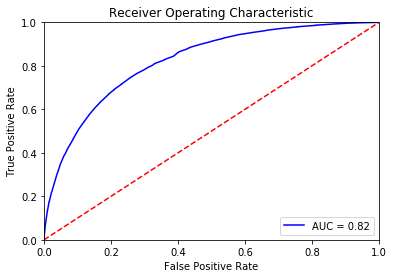

In [35]:
# print("Model Training and Hyper-parameters Tuning for Random Forest\n")
# print("TRAIN PERFORMANCE:")
# generic_tf_rf, _ = geneClassifier_tf.train_model('RandomForestClassifier', True)
# print("TEST PERFORMANCE:")
# result = geneClassifier_tf.test_model(generic_tf_rf,generic_X_test_tf,generic_y_test_tf,True,model_name="RandomForestClassifier")

#### Gradient Boosting:

Model with **n_estimators=20** trained on generic_tweeters only got the training accuracy of **62.3%**, and got the test accuracy of **62.1%**. Since Gradient Boosting's performance is significantly worse than over algorithms and training Gradient Boosting with large number of neighbors is really time consuming, I decided not to conduct grid search on Gradient Boosting.

Model Training and Hyper-parameters Tuning for Gradient Boost

TRAIN PERFORMANCE:
Train accuracy of GradientBoostingClassifier model is 0.6228661107967587

TEST PERFORMANCE:
Model GradientBoostingClassifier has test accuracy 0.6206406935033878

Test result report:

               precision    recall  f1-score   support

           0       0.60      0.95      0.74     22357
           1       0.76      0.21      0.33     17787

    accuracy                           0.62     40144
   macro avg       0.68      0.58      0.53     40144
weighted avg       0.67      0.62      0.56     40144
 

ROC plot and corresponding AUC:



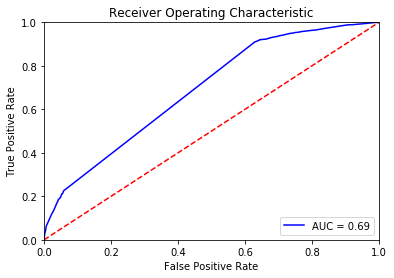

In [36]:
print("Model Training and Hyper-parameters Tuning for Gradient Boost\n")
print("TRAIN PERFORMANCE:")
generic_tf_gb, _ = geneClassifier_tf.train_model('GradientBoostingClassifier')
print("TEST PERFORMANCE:")
result = geneClassifier_tf.test_model(generic_tf_gb,generic_X_test_tf,generic_y_test_tf,True,model_name="GradientBoostingClassifier")

#### Conclusion:
Now we obtained the training and testing accuracy of three type of features with LogisticRegression:

|  Classifier       |train_acc|test_acc|
|---                |---      |---   | 
|Logistic Regression|86.3%    |76.7%|
|Naive Bayes        |85.9%    |75.6%|
|K Nearest Neighbor |71.3%    |57.5%|
|Linear SVC         |84.4%    |76.7%|
|Decision Tree      |99.4%    |70.0%|
|Random Forest      |99.4%    |74.6%|
|Gradient Boosting  |62.3%    |62.1%|

From the test accuracy, we can conclude that **Logistic Regression**, despite its simplicity, is the best classifier among all algorithms.

#### 4.1.2 Evaluate the same model with best performance on the 2019 Canadian elections data. How well do your predictions match the sentiment labelled in the 2019 Canadian elections data?
#### Logistic regression is the best performing model in terms of test accuracy for generic tweets, therefore it is used on the election tweets.

Change negative reasons to numeric labels

In [65]:
election_tweets['class'] = [1 if row['sentiment']=='Positive' else 0 for index,row in election_tweets.iterrows()]
election_X_tf = feature_list_tf.transform(election_tweets['cleaned'].apply(lambda x:" ".join(x)))
election_tweets.head()

,sentiment,negative_reason,text,cleaned,party,class
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, instead, suggestion, agree, cana...",Conservative Party,0
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[allwomanspacewalk, real, n, space_station, n,...",Other,1
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, billion, next, years,...",Liberal Party,0
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[canada, canadaelection2019, canadavotes, n, n...",Other,1
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, tired, hard, earned,...",Liberal Party,0


Model LogisticRegression has test accuracy 0.6010314111579934

Test result report:

               precision    recall  f1-score   support

           0       0.58      0.59      0.58      1006
           1       0.62      0.61      0.62      1127

    accuracy                           0.60      2133
   macro avg       0.60      0.60      0.60      2133
weighted avg       0.60      0.60      0.60      2133
 

ROC plot and corresponding AUC:



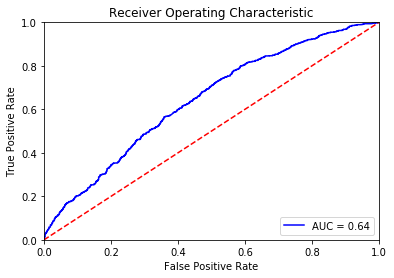

In [68]:
result = geneClassifier_tf.test_model(generic_tf_lr,election_X_tf,election_tweets['class'],True,model_name='LogisticRegression')

From the result above, you can see that the **Logistic Regression** model trained on generic tweets performs worse on election tweets than on generic tweets.  This model gets a test accuracy of **60.1%** compared to **76.7%**, and gets s AUC value of **0.64** compared to **0.85**. Potential reason why this happens is that different topics have different text features. 

### 4.2 Task 2
#### 4.2.1 Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 3 parties. 

**Logistic Regression** has the best performance according to the above analysis. Therefore **Logistic Regression** model with **TF-IDF** input features trained on generic tweets is used to predict sentiments of election tweets.

In [175]:
election_tweets['pred_tf_lr'] = generic_tf_lr.predict(election_X_tf)

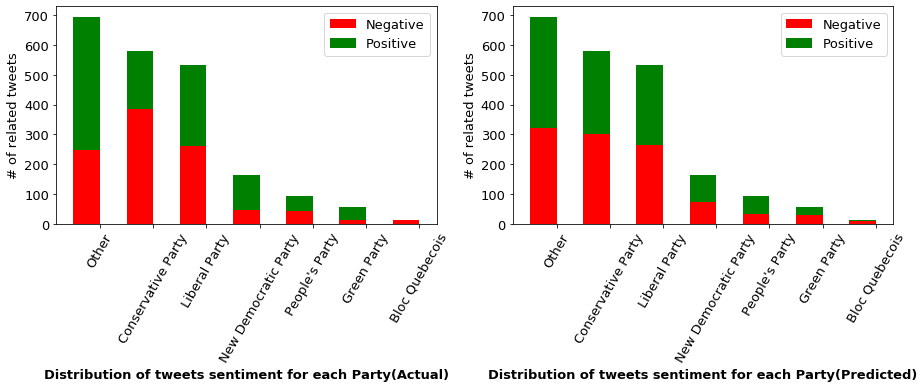

In [176]:
num,ratio = ratio_2d(election_tweets,parties,'party','Negative','sentiment')

negative = num * ratio
positive = num * (1-ratio)

plt.figure(figsize=(15,4))

fig1 = plt.subplot(1, 2, 1)
plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(parties))
plt.bar(idx, negative, width, color='red', label='Negative')
plt.bar(idx, positive, width, bottom=negative, color='green', label='Positive')
plt.xlabel('Distribution of tweets sentiment for each Party(Actual)',fontweight='bold')
plt.ylabel('# of related tweets')
plt.xticks(idx+width/2, parties, rotation=60)
plt.legend()

num,ratio = ratio_2d(election_tweets,parties,'party',0,'pred_tf_lr')

negative = num * ratio
positive = num * (1-ratio)

fig2 = plt.subplot(1, 2, 2)
plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(parties))
plt.bar(idx, negative, width, color='red', label='Negative')
plt.bar(idx, positive, width, bottom=negative, color='green', label='Positive')
plt.xlabel('Distribution of tweets sentiment for each Party(Predicted)',fontweight='bold')
plt.ylabel('# of related tweets')
plt.xticks(idx+width/2, parties, rotation=60)
plt.legend()

#### 4.2.2 Compare your modeling results with election outcome. Discuss whether NLP analytics based on tweets is useful for political parties during election campaigns.

Based on the Distribution of tweets sentiment for each Party(**actual**), Although total number of Conservative Party related tweets is slightly higher than that of Liberal Party related tweets, the negative portion of the Conservative Party related tweets is significantly higher than that of Liberal Party. This explains why Liberal Party wins the election. 

Based on the Distribution of tweets sentiment for each Party(**predicted**), the ratios between negative and postive tweets for all parties are close to 50:50. This is consistent with the overall 60% test accuracy of the model. This indicates that model that based on generic tweets doesn't generalize well to election related tweets. And topics of tweets can be quite different in terms of input features.

### 4.3 Task 3
#### 4.3.1 Split the negative 2019 Canadian elections tweets into training data (70%) and test data (30%). Use the sentiment labels in the 2019 Canadian elections data instead of your predictions from the previous part.

Negative reasons in text are converted to numeric labels for easy classifier implementation

In [106]:
print(neg_reasons)

['Others', 'Scandal', 'Tell lies', 'Economy', 'Women Reproductive right and Racism', 'Climate Problem', 'Separation', 'Privilege', 'Healthcare', 'Healthcare and Marijuana']


From the above result, we can see there are 10 different reasons. "Healthcare" and "Healthcare and Marijuana" are all about healthcare, so we merge them into same reason "Healthcare". 

In [111]:
negative_election_tweets_new = neg_election_tweets.copy()
negative_election_tweets_new['negative_reason']=np.where(negative_election_tweets_new['negative_reason'] =='Healthcare and Marijuana', 'Healthcare', negative_election_tweets_new['negative_reason'])
negative_election_tweets_new['negative_reason']=np.where(negative_election_tweets_new['negative_reason'] =='Healthcare', 'Healthcare', negative_election_tweets_new['negative_reason'])


In [112]:
# Here we have a total of 10 reasons for negative sentiment. 
# We map different reasons to different labe.

def LabelReason(data):
    all_reason = {"Others":0,'Scandal':1,'Tell lies':2,'Economy':3,'Women Reproductive right and Racism':4,\
                  'Climate Problem':5,'Separation':6,'Privilege':7,'Healthcare':8}
    return all_reason[data]
# negative_election_tweets_new = negative_election_tweets_new.copy()
negative_election_tweets_new.loc[:,'class'] = np.vectorize(LabelReason)(negative_election_tweets_new['negative_reason'])
negative_election_tweets_new.head()

,sentiment,negative_reason,text,cleaned,party,class,pred_tf_lr
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, instead, suggestion, agree, cana...",Conservative Party,4,0
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, billion, next, years,...",Liberal Party,3,0
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, tired, hard, earned,...",Liberal Party,3,0
5,Negative,Others,"b""#CanadaVotes2019 #elxn43 #cdnpoli - FACTS - ...","[canadavotes2019, facts, blastfromthepast, con...",Conservative Party,0,1
8,Negative,Others,"b""#chooseforward #cdnpoli #elxn43\nCanada, Don...","[chooseforward, ncanada, make, america, mistak...",Liberal Party,0,1


#### TF-IDF is used as input features, negative 2019 Canadian elections tweets are split into training data (70%) and test data (30%)

In [113]:
negaGenerator = DataGenerator(negative_election_tweets_new)
neg_X_tf, neg_Y_tf,neg_feature_tf = negaGenerator.generate("cleaned","class","tf-idf")
neg_X_train_tf,neg_X_test_tf,neg_y_train_tf,neg_y_test_tf = negaGenerator.split_data(neg_X_tf,neg_Y_tf,percent=[0.7,0.3])

#### 4.3.2 Choose three algorithms from classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)), train multi-class classification models to predict the reason for the negative tweets. There are 10 different negative reasons labelled in the dataset. Feel free to combine similar reasons into fewer categories as long as you justify your reasoning. You are free to define input features of your model using word frequency analysis or other techniques.

Three algorithms are choosed for negative reasons prediction for negative election tweets, namely **Logistic Regression, Linear SVC and Random Forest**.

Classifier is only applied on training data for negative election tweets.

In [114]:
negClassifier_tf = Classifier(neg_X_train_tf,neg_y_train_tf)

In [115]:
neg_tf_lr,_ = negClassifier_tf.train_model('LogisticRegression')
_, neg_cm_tf_lr = negClassifier_tf.test_model(neg_tf_lr,neg_X_test_tf,neg_y_test_tf,model_name="LogisticRegression")

Train accuracy of LogisticRegression model is 0.9957386363636364

Model LogisticRegression has test accuracy 0.5629139072847682



In [116]:
neg_tf_lsvc,_ = negClassifier_tf.train_model('LinearSVC')
_, neg_cm_tf_lsvc = negClassifier_tf.test_model(neg_tf_lsvc,neg_X_test_tf,neg_y_test_tf,model_name="LinearSVC")

Train accuracy of LinearSVC model is 0.9815340909090909

Model LinearSVC has test accuracy 0.5662251655629139



In [117]:
neg_tf_rf,_ = negClassifier_tf.train_model('RandomForestClassifier')
_, neg_cm_tf_rf = negClassifier_tf.test_model(neg_tf_rf,neg_X_test_tf,neg_y_test_tf,model_name="RandomForestClassifier")

Train accuracy of RandomForestClassifier model is 0.9971590909090909

Model RandomForestClassifier has test accuracy 0.5629139072847682



#### Algorithm Comparision:
|  Model            |train_acc|test_acc|
|---                |---   |---   | 
|Logistic Regression|99.5%|56.3%|
|Linaer SVC         |97.9%|56.6%|
|Random Forest      |99.7%|56.3%|

Performances are similar across the board. **Linear SVC** turned out to be slightly better than the rest in terms of testing accuracy 

## 5 Results (20 marks):
Answer the research question stated above based on the outputs of your first model.
Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value. For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. For both models, suggest one way you can improve the accuracy of your models.

In [118]:
election_tweets['pred_tf_lr'] = generic_tf_lr.predict(election_X_tf)

In [128]:
election_tweets.head()

,sentiment,negative_reason,text,cleaned,party,class,pred_tf_lr
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ...","[rosiebarton, instead, suggestion, agree, cana...",Conservative Party,0,0
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio...","[allwomanspacewalk, real, n, space_station, n,...",Other,1,1
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO...","[brantford, going, cost, billion, next, years,...",Liberal Party,0,0
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#...","[canada, canadaelection2019, canadavotes, n, n...",Other,1,0
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h...","[canada, taxpayers, sick, tired, hard, earned,...",Liberal Party,0,0


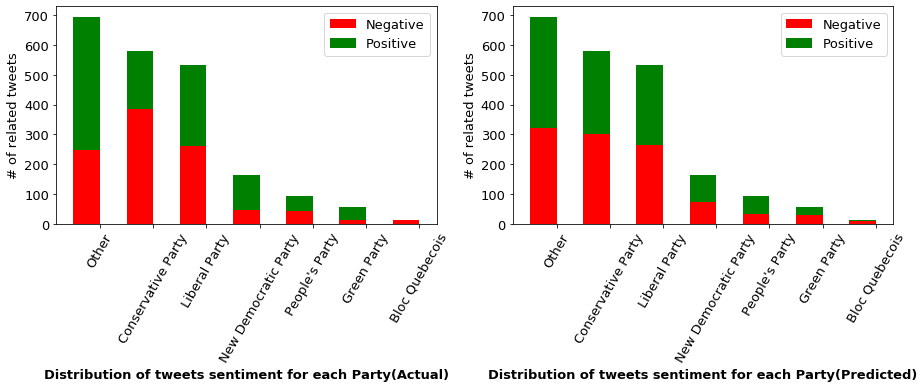

In [177]:
num,ratio = ratio_2d(election_tweets,parties,'party','Negative','sentiment')

negative = num * ratio
positive = num * (1-ratio)

plt.figure(figsize=(15,4))

fig1 = plt.subplot(1, 2, 1)
plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(parties))
plt.bar(idx, negative, width, color='red', label='Negative')
plt.bar(idx, positive, width, bottom=negative, color='green', label='Positive')
plt.xlabel('Distribution of tweets sentiment for each Party(Actual)',fontweight='bold')
plt.ylabel('# of related tweets')
plt.xticks(idx+width/2, parties, rotation=60)
plt.legend()

num,ratio = ratio_2d(election_tweets,parties,'party',0,'pred_tf_lr')

negative = num * ratio
positive = num * (1-ratio)

fig2 = plt.subplot(1, 2, 2)
plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(parties))
plt.bar(idx, negative, width, color='red', label='Negative')
plt.bar(idx, positive, width, bottom=negative, color='green', label='Positive')
plt.xlabel('Distribution of tweets sentiment for each Party(Predicted)',fontweight='bold')
plt.ylabel('# of related tweets')
plt.xticks(idx+width/2, parties, rotation=60)
plt.legend()

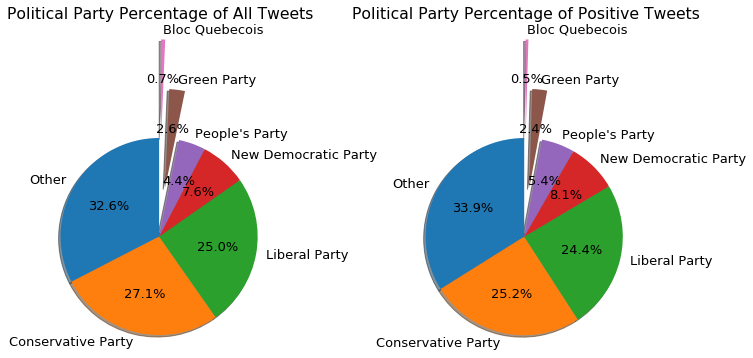

In [156]:
# Plot of Party Percentage on Positive Tweets
positive_num = num * (1-ratio)
plt.figure(figsize=(12,6))

fig1 = plt.subplot(121)
plt.title('Political Party Percentage of All Tweets')
plt.pie(num,labels=parties,explode=(0,0,0,0,0,0.5,1.0),\
       labeldistance = 1.1,autopct = '%3.1f%%',shadow = True, startangle = 90,pctdistance = 0.6)
plt.axis('equal')

fig2 = plt.subplot(122)
plt.title('Political Party Percentage of Positive Tweets')
plt.pie(positive_num,labels=parties,explode=(0,0,0,0,0,0.5,1.0),\
       labeldistance = 1.1,autopct = '%3.1f%%',shadow = True, startangle = 90,pctdistance = 0.6)
plt.axis('equal')
plt.show()

### 5.1 Answer the research question stated above based on the outputs of your first model. Describe the results of the analysis and discuss your interpretation of the results. Explain how each party is viewed in the public eye based on the sentiment value. 

Based on the Distribution of tweets sentiment for each Party(**actual**), Although total number of Conservative Party related tweets is slightly higher than that of Liberal Party related tweets, the negative portion of the Conservative Party related tweets is significantly higher than that of Liberal Party. This explains why Liberal Party wins the election. 

Based on the Distribution of tweets sentiment for each Party(**predicted**), the ratios between negative and postive tweets for all parties are close to 50:50. This is consistent with the overall 60% test accuracy of the model. This indicates that model that based on generic tweets doesn't generalize well to election related tweets. And topics of tweets can be quite different in terms of input features.

Base on comparison between "Political Party Percentage of All Tweets" and "Political Party Percentage of Positive Tweets", we can conclude that Conservative Party leads both in percentage of all tweets and percentage of positive tweets. It is the overwhelming negative tweets of Conservative Party that causes it to lose the election eventually.

In [163]:
negative_election_tweets_new['pred_tf_lr'] = neg_tf_lr.predict(neg_X_tf)

[[94 22  3  0  0  0  0  0  0]
 [27 43  3  0  0  0  0  0  0]
 [30 12 20  2  0  0  0  0  0]
 [ 3  1  2  4  0  0  0  0  0]
 [ 3  3  0  0  2  0  0  0  0]
 [10  1  1  1  0  6  0  0  0]
 [ 2  1  0  0  0  0  1  0  0]
 [ 2  0  0  1  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0]]


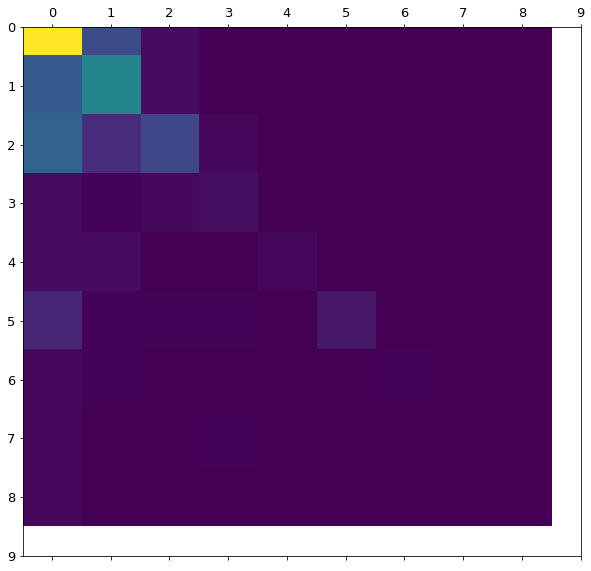

In [164]:
print(neg_cm_tf_lr)
negClassifier_tf.plot_confusion_matrix(neg_cm_tf_lr)

In [172]:
# confuse_2_1 is the tweets which belong to "Tell lies" but are classified as "Scandal"
confuse_2_1 = negative_election_tweets_new[(negative_election_tweets_new['class']==2) & (negative_election_tweets_new['pred_tf_lr']==1)]
print(confuse_2_1['text'][0:4])

15     b"#LyingAndy has a history of not answering em...
46     b"@C_Resists @gill_godwin Name me one election...
54     b"@Charliekuss @Roy_Woodhall @nunnya16 @Yukon_...
607    b'#Scheer called for a campaign of misinformat...
Name: text, dtype: object


In [173]:
# confuse_1_2 is the tweets which belong to "Scandal" but are classified as "Tell lies"
confuse_1_2 = negative_election_tweets_new[(negative_election_tweets_new['class']==1) & (negative_election_tweets_new['pred_tf_lr']==2)]
print(confuse_1_2['text'][0:4])

115    b"@MichaelCowtan @telfordk Yes, he will allow ...
381    b"Lol this is so silly, every party has people...
486    b"This is appalling. The most slimy politickin...
Name: text, dtype: object


### 5.2 For the second model, based on the model that worked best, provide a few reasons why your model may fail to predict the correct negative reasons. Back up your reasoning with examples from the test sets. 

Based on the performance of second model, we plotted confusion matrix of nine negative reasons, where {'Others':0, 'Scandal':1, 'Tell lies':2, 'Economy':3, 'Women Reproductive right and Racism':4, 'Climate Problem':5, 'Separation:6', 'Privilege':7, 'Healthcare':8}.

Since reason class0(Other) is pretty vague, it is not surprising that it gets confused easily with other reasons. Here we are going to focus on the confusion between **class1(Scandal)** and **class2(Tell lies)** instead. 

Example of **class2(Tell lies)** falsely classified as **class1(Scandal)**:

No.607: b'#Scheer called for a campaign of misinformation. Instead its campaign of smear. Parliamentary experts say complete nonsense to who he says should get gov. + Still saying nothing about Trump schenanigans that islolateCanada.\xf0\x9f\x99\x84Numbskull! #cdnpoli #elxn43 https://t.co/bMDf3c8Ojp'

#### No. 607 talks about Scheer has some conspiracy business going on with Trump, which is labeled as Tell lies but can be perceived as Scandal as well.

Example of **class1(Scandal)** falsely classified as **class2(Tell lies)**:

No. 486: b"This is appalling. The most slimy politicking imaginable. @JustinTrudeau betrayed the Canadian people and denied them real democracy after promising it *1800* times. Now he won't even answer a question about it. Because he knows there's no decent answer. #cdnpoli #elxn43 #Vote4PR https://t.co/7D0Xtk4arb"

#### No. 486 talks about Trudeau denied real democracy after promising it, which is labeled as Scandal but can be perceived as Tell lies as well.

### 5.3 For both models, suggest one way you can improve the accuracy of your models.

For first model trained on generic tweets to predict election tweets sentiment:
- Feature Construction. Use more comprehensive feature construction methods that take into account more than word frequency, like phrase etc.
- Improve data quality, try not to include meaningless tweets

For second model trained on negative election tweets to prediction negative reasons:
- Feature Selection. Do feature selection on constructed features to choose the features that are more informative to the labels.
- Include more data, around 2000 total tweets is not enough. Hyperparameter tuning on models. 

## 6. Bonus

### 6.1 Try word embeddings and N-grams as feature engineering techniques in addition to WF and TF-IDF.
#### 6.1.1 Word embeddings

In [179]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)
#min_count= int Ignores all words with total absolute frequency lower than this - (2, 100)
#window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
#size = int - Dimensionality of the feature vectors. - (50, 300)
#sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
#alpha = float - The initial learning rate - (0.01, 0.05)
#min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
#negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
#workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

# Word2Vec requires tokenized lists as input, which we prepared when cleaning our text
sentences=election_tweets['cleaned']

w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
#total_examples = int - Count of sentences;
#epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

w2v_model.init_sims(replace=True)# make the model much more memory-efficient:

#Here, we will ask our model to find the words most and least similar to coronavirus, the stemmed version of 'Corona-virus'
# print(w2v_model.wv.most_similar(positive=["coronavirus"]))

# print(w2v_model.wv.most_similar(negative=["coronavirus"]))

#word2vec = pd.DataFrame(w2v_model.init_sims(replace=True))

In [181]:
a=[]
for keys in w2v_model.wv.vocab.keys():
    a.append(w2v_model.wv.get_vector(keys))
matrix = pd.DataFrame(a)
matrix = np.transpose(matrix)

matrix.columns=w2v_model.wv.vocab.keys()
matrix

,rosiebarton,canadian,women,andrewscheer,conservatives,government,right,let,go,canada,abortion,real,n,onpoli,going,next,years,ask,justin,canadavotes,help,hard,need,one,many,trudeaumustgo,care,election2019,canadavotes2019,end,even,public,cdnmedia,ppc,best,election,ever,please,liberals,ndp,seems,chooseforward,make,full,via,see,warren,kinsella,two,days,away,voting,day,read,vote,trudeau,lpc,monday,night,support,bc,thanks,people,party,mp,elizabethmay,questions,answer,trump,working,campaign,yes,cpc_hq,candidate,uprisingh,country,today,change,world,watch,news,conservative,firm,us,ppc2019,policy,cpc,kinsellagate,pm,deserve,better,federal,want,alberta,ontario,issue,liberal_party,justintrudeau,could,put,social,media,getting,love,well,believe,back,like,voters,vankayak,milton,yet,canadians,come,show,new,story,liberal,smear,life,also,everyone,else,much,little,canadiangreens,get,money,take,thank,climate,parties,work,way,ableg,skpoli,bcpoli,free,would,know,said,itsourvote,good,true,hope,since,harper,leader,question,hired,time,anyone,green,oil,nothing,done,give,plan,cbckatie,look,andy,must,stop,job,first,things,cons,important,issues,ni,scheerlies,group,scheerdisaster,chooseforwardwithtrudeau,ctvnews,final,nand,remember,jkenney,polcan,abpoli,oh,last,big,tell,power,thejagmeetsingh,scheer,worked,tweet,got,lying,man,globeandmail,polls,kinsellawarren,maximebernier,still,really,lies,dirty,votes,win,andrew,fake,sure,nthe,needs,politics,october,someone,future,think,majority,platform,peoplespca,home,mps,left,supporters,american,voted,nhe,candidates,may,another,never,past,says,lie,riding,far,maybe,use,great,greens,made,paid,destroy,cbc,knock,guy,ready,rights,live,pay,asked,political,anything,choose,respect,bernier,cndpoli,lot,every,economy,canpoli,say,keep,team,actually,old,ottawa,minister,bad,thing,endorsement,prime,jagmeet,singh,doors,stand
0,-0.044383,-0.043086,-0.043051,-0.043965,-0.043702,-0.043446,-0.044678,-0.044148,-0.044778,-0.044570,-0.043391,-0.043002,-0.044031,-0.043837,-0.043542,-0.043227,-0.043408,-0.044056,-0.042923,-0.044477,-0.043346,-0.044565,-0.043935,-0.043526,-0.044361,-0.044452,-0.042873,-0.043441,-0.042955,-0.043709,-0.044450,-0.044086,-0.043184,-0.044076,-0.044104,-0.043594,-0.044492,-0.043723,-0.044386,-0.043689,-0.043090,-0.043133,-0.043034,-0.044538,-0.044599,-0.044265,-0.043341,-0.043225,-0.043880,-0.043329,-0.043141,-0.044697,-0.044112,-0.043531,-0.043044,-0.043839,-0.044408,-0.043530,-0.044253,-0.044097,-0.044295,-0.044386,-0.043196,-0.043593,-0.043051,-0.044082,-0.043071,-0.043754,-0.044529,-0.042997,-0.044054,-0.044533,-0.044113,-0.044191,-0.044600,-0.043208,-0.043785,-0.044334,-0.044601,-0.044013,-0.043641,-0.043907,-0.044243,-0.044795,-0.043249,-0.044640,-0.043665,-0.044267,-0.044171,-0.043145,-0.043553,-0.043525,-0.044635,-0.043952,-0.043974,-0.044025,-0.043555,-0.044429,-0.042965,-0.043469,-0.043433,-0.044105,-0.043991,-0.042961,-0.044754,-0.043547,-0.043249,-0.043456,-0.044410,-0.043307,-0.042928,-0.044697,-0.044445,-0.043799,-0.044517,-0.042935,-0.042859,-0.043276,-0.044385,-0.044169,-0.043755,-0.044074,-0.044118,-0.044443,-0.043479,-0.043720,-0.043442,-0.043482,-0.043199,-0.042937,-0.043763,-0.043559,-0.044441,-0.042968,-0.043550,-0.044357,-0.043080,-0.044309,-0.043024,-0.043624,-0.043746,-0.043843,-0.044088,-0.043193,-0.044502,-0.043951,-0.044138,-0.044009,-0.044431,-0.044193,-0.044412,-0.044553,-0.043963,-0.043561,-0.044363,-0.044013,-0.043094,-0.043038,-0.043072,-0.043343,-0.043490,-0.044596,-0.044346,-0.043659,-0.043184,-0.043979,-0.043557,-0.042842,-0.043281,-0.043829,-0.042852,-0.044585,-0.044409,-0.044320,-0.042928,-0.043839,-0.043585,-0.043711,-0.044783,-0.044801,-0.043314,-0.042993,-0.043015,-0.044425,-0.044453,-0.043395,-0.043277,-0.042886,-0.044153,-0.043146,-0.043783,-0.043966,-0.044180,-0.043252,-0.043068,-0.044155,-0.043974,-0.044210,-0.044018,-0.044477,-0.044636,-0.043213,-0.043189,-0.044110,-0.043139,-0.043263,-0.043630,-0.044257,-0.043191,-0.043237,-0.044531,-0.043882,-0.044607,-0.044426,-0.043329

In [182]:
### Plotting our Word2Vec results for visualizing our vocabulary in 2D space

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    
    plt.title('t-SNE visualization for {}'.format(word.title()), fontsize=20)
    
    red_patch = mpatches.Patch(color='red', label='Target word')
    green_patch = mpatches.Patch(color='green', label='Similar words')
    red_dot, = plt.plot(500, "ro", markersize=5)
    green_dot, = plt.plot(500, "go", markersize=5)
    plt.legend([red_dot, (red_dot, green_dot)], ["Target word", "Similar words"])

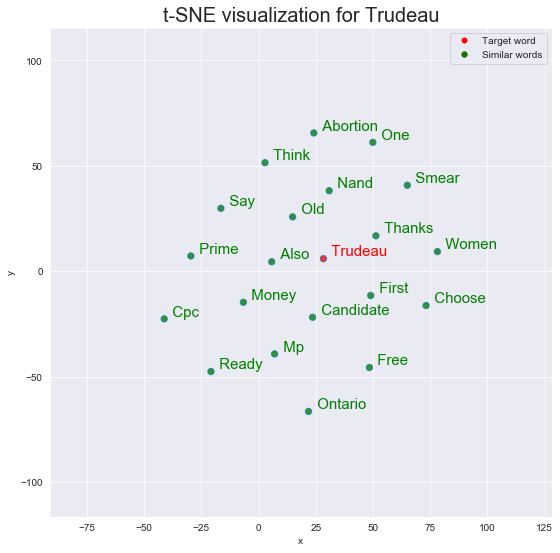

In [186]:
target = 'trudeau'
tsnescatterplot(w2v_model, target, [t[0] for t in w2v_model.wv.most_similar(positive=[target], topn=20)][10:])

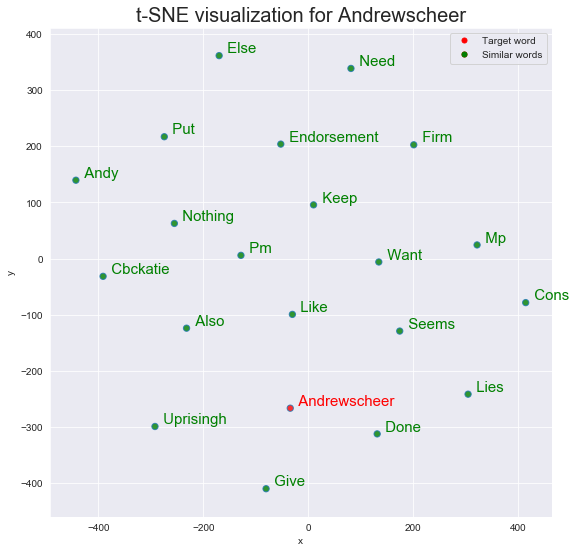

In [188]:
target = 'andrewscheer'
tsnescatterplot(w2v_model, target, [t[0] for t in w2v_model.wv.most_similar(positive=[target], topn=20)][10:])

#### 6.1.2 N-grams

#### Calculate 10 most common 6-grams of election positive tweets

In [189]:
import collections # high performace data type
import re
import sys
import time


def wordtokenize(str_):
    """
    convert to lowercase and split into words ignoring punctuation
    """
    return re.findall(r'\w+', str_.lower())

def counting_ngrams(lines, min_length=2, max_length=4):
    """Iterate through given lines (file object or list of
    lines) and return n-gram frequencies. The return value will be a dictionary
    mapping out the the length of the n-gram to collections.Counter
    object of n-gram tuple and number of times that n-gram occurred.
    Returned dict includes n-grams of length min_length to max_length.
    """
    lengths = range(min_length, max_length + 1)
    ngrams = {length: collections.Counter() for length in lengths}
    queue = collections.deque(maxlen=max_length)

    # Helper function to add n-grams at start of current queue to dict
    def add_queue():
        current = tuple(queue)
        for length in lengths:
            if len(current) >= length:
                ngrams[length][current[:length]] += 1

    # Loop through all lines and words and add n-grams to dict
    for line in lines:
        for word in wordtokenize(line):
            queue.append(word)
            if len(queue) >= max_length:
                add_queue()

    # Make sure we get the n-grams at the tail end of the queue
    while len(queue) > min_length:
        queue.popleft()
        add_queue()

    return ngrams


def print_most_frequent(ngrams, num=10):
    """Print num most common n-grams of each length in n-grams dict."""
    for n in sorted(ngrams):
        print('----- {} most common {}-grams -----'.format(num, n))
        for gram, count in ngrams[n].most_common(num):
            print('{0}: {1}'.format(' '.join(gram), count))
        print('')

In [192]:
election_positive=election_tweets[election_tweets['sentiment']=='Positive']['cleaned'].apply(lambda x:" ".join(x))
election_positive_ngram=" ".join(election_positive)
a = wordtokenize(election_positive_ngram)
b = counting_ngrams(a, min_length=6, max_length=6)
print_most_frequent(b, num=10)

----- 10 most common 6-grams -----
n onpoli nspoli ontpoli abpoli nlpoli: 9
onpoli nspoli ontpoli abpoli nlpoli skpoli: 9
nspoli ontpoli abpoli nlpoli skpoli mbpoli: 9
ontpoli abpoli nlpoli skpoli mbpoli nbpoli: 9
abpoli nlpoli skpoli mbpoli nbpoli nwtpoli: 9
nlpoli skpoli mbpoli nbpoli nwtpoli qcpoli: 9
skpoli mbpoli nbpoli nwtpoli qcpoli nspolitics: 9
mbpoli nbpoli nwtpoli qcpoli nspolitics peipoli: 9
access globe starts today runs election: 8
globe starts today runs election election: 8



#### Above shows the 10 most common 6-grams of election positive tweets

### 6.2 While the exploratory analysis section requires only two figures, you can explore the data further. You can also display the results of the model visually.

Please refer to section 2.3 Exploratory analysis Bonus

### 6.3 Instead of choose three algorithms from classification algorithms (logistic regression, k-NN, Naive Bayes, SVM, decision trees, ensembles (Random Forest, XGBoost)) for negative reasons classification, we use all of them and compare the result

In [193]:
neg_tf_nb,_ = negClassifier_tf.train_model('MultinomialNB')
_, neg_cm_tf_nb = negClassifier_tf.test_model(neg_tf_nb,neg_X_test_tf,neg_y_test_tf,model_name="MultinomialNB")

Train accuracy of MultinomialNB model is 0.8167613636363636

Model MultinomialNB has test accuracy 0.48013245033112584



In [194]:
neg_tf_knn,_ = negClassifier_tf.train_model('KNeighborsClassifier')
_, neg_cm_tf_knn = negClassifier_tf.test_model(neg_tf_knn,neg_X_test_tf,neg_y_test_tf,model_name="KNeighborsClassifier")

Train accuracy of KNeighborsClassifier model is 0.39488636363636365

Model KNeighborsClassifier has test accuracy 0.4205298013245033



In [195]:
neg_tf_dt,_ = negClassifier_tf.train_model('DecisionTreeClassifier')
_, neg_cm_tf_dt = negClassifier_tf.test_model(neg_tf_dt,neg_X_test_tf,neg_y_test_tf,model_name="DecisionTreeClassifier")

Train accuracy of DecisionTreeClassifier model is 1.0

Model DecisionTreeClassifier has test accuracy 0.5099337748344371



In [196]:
neg_tf_gb,_ = negClassifier_tf.train_model('GradientBoostingClassifier')
_, neg_cm_tf_gb = negClassifier_tf.test_model(neg_tf_gb,neg_X_test_tf,neg_y_test_tf,model_name="GradientBoostingClassifier")

Train accuracy of GradientBoostingClassifier model is 0.7457386363636364

Model GradientBoostingClassifier has test accuracy 0.5662251655629139



#### Algorithm Comparision:
|  Model            |train_acc|test_acc|
|---                |---   |---   | 
|Logistic Regression|99.5%|56.3%|
|Linear SVC         |97.9%|56.6%|
|Random Forest      |99.7%|56.3%|
|Naive Bayes        |81.6%|48.0%|
|K Nearest Neighbor |39.5%|42.1%|
|Decision Tree      |100.%|51.0%|
|Gradient Boosting  |74.6%|56.6%|

Performances are similar across the board. **Linear SVC** turned out to be slightly better than the rest in terms of testing accuracy. 

Interestingly, decision tree received a perfect 100% training accruacy but do not generalize well. K nearest neighbor is completely useless in multi-class classification with small amount of neighbors